In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn import metrics

from sklearn.model_selection import train_test_split

%matplotlib inline

#sns.set(style='whitegrid', palette='muted', font_scale=1.5)

#rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

In [3]:
columns = ['x-axis', 'y-axis','z-axis','xg-axis', 'yg-axis','zg-axis','activity']
df=pd.read_csv("Act3_noise.csv",names=columns,skiprows=1)


In [4]:
df

,x-axis,y-axis,z-axis,xg-axis,yg-axis,zg-axis,activity
0,1.0000,2.0000,3.0000,4.0000,5.0000,6.0000,1
1,0.2811,0.1274,0.9778,-3.9024,-1.8293,4.2073,1
2,0.2809,0.1324,0.9744,-2.8659,-2.6829,3.8415,1
3,0.2870,0.1294,0.9727,-3.1707,-2.6829,3.7805,1
4,0.2906,0.1288,0.9706,-3.5976,-2.5000,3.9024,1
...,...,...,...,...,...,...,...
56880,-0.7617,0.2175,0.4307,-51.7073,-60.1829,-20.0000,2
56881,-0.7954,0.2493,0.5015,-47.7439,-57.6829,-18.7195,2
56882,-0.7488,0.2690,0.5981,-47.6829,-64.2683,-9.8780,2
56883,-0.7128,0.2090,0.5511,-49.6341,-64.6341,-4.3902,2


In [5]:
tf.__version__

'1.4.0'

In [6]:
df.shape

(56885, 7)

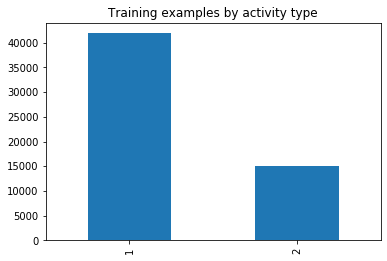

In [7]:
df['activity'].value_counts().plot(kind='bar', title='Training examples by activity type');

In [8]:
N_TIME_STEPS = 500
N_FEATURES = 6
step = 100
segments = []
labels = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    xs = df['x-axis'].values[i: i + N_TIME_STEPS]
    ys = df['y-axis'].values[i: i + N_TIME_STEPS]
    zs = df['z-axis'].values[i: i + N_TIME_STEPS]
    xsg = df['xg-axis'].values[i: i + N_TIME_STEPS]
    ysg = df['yg-axis'].values[i: i + N_TIME_STEPS]
    zsg = df['zg-axis'].values[i: i + N_TIME_STEPS]
    label = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
    #print label
    segments.append([xs, ys, zs, xsg, ysg, zsg])
    labels.append(label)
    #print labels

In [9]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [10]:
reshaped_segments.shape

(564, 500, 6)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)

In [12]:
X_train.shape

(451, 500, 6)

In [13]:
X_test.shape

(113, 500, 6)

In [14]:
N_CLASSES = 2
N_HIDDEN_UNITS = 64

In [15]:
def create_LSTM_model(inputs):
    W = {
        'hidden': tf.Variable(tf.random_normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.Variable(tf.random_normal([N_HIDDEN_UNITS, N_CLASSES]))
    }
    biases = {
        'hidden': tf.Variable(tf.random_normal([N_HIDDEN_UNITS], mean=1.0)),
        'output': tf.Variable(tf.random_normal([N_CLASSES]))
    }
    
    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, N_FEATURES])
    hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])
    hidden =tf.split(hidden, N_TIME_STEPS, 0)

    # Stack 2 LSTM layers
    
    lstm_layers = [tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.contrib.rnn.MultiRNNCell(lstm_layers)

    outputs, _ = tf.contrib.rnn.static_rnn(lstm_layers, hidden, dtype=tf.float32)

    # Get output for the last time step
    lstm_last_output = outputs[-1]

    return tf.matmul(lstm_last_output, W['output']) + biases['output']

In [16]:
#tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name="input")
Y = tf.placeholder(tf.float32, [None, N_CLASSES])

In [17]:
pred_Y = create_LSTM_model(X)

pred_softmax = tf.nn.softmax(pred_Y, name="y_")

In [18]:
L2_LOSS = 0.0015

l2 = L2_LOSS * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = Y)) + l2

In [19]:
LEARNING_RATE = 0.00025
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

In [20]:
N_EPOCHS = 40
BATCH_SIZE = 128

In [21]:
saver = tf.train.Saver()

history = dict(train_loss=[], 
                     train_acc=[], 
                     test_loss=[], 
                     test_acc=[])

sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_count = len(X_train)

for i in range(1, N_EPOCHS + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1,BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end],
                                       Y: y_train[start:end]})

    _, acc_train, loss_train = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_train, Y: y_train})

    _, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_test, Y: y_test})

    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)
    #if i != 1 and i % 10 != 0:
        #continue

    print("epoch " + str(i) + ":  "+ "test accuracy:" + " " + str(acc_test) + " " + "loss:" + str(loss_test))
    
predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

#print()
print("final results: accuracy:   " + str(acc_final) + "\t" +  "loss:  " +str(loss_final))

epoch 1:  test accuracy: 0.8141593 loss:1.1825163
epoch 2:  test accuracy: 0.8318584 loss:1.1583028
epoch 3:  test accuracy: 0.8495575 loss:1.1218114
epoch 4:  test accuracy: 0.8584071 loss:1.0951799
epoch 5:  test accuracy: 0.8584071 loss:1.0872326
epoch 6:  test accuracy: 0.8584071 loss:1.0649724
epoch 7:  test accuracy: 0.8584071 loss:1.0546066
epoch 8:  test accuracy: 0.86725664 loss:1.0221424
epoch 9:  test accuracy: 0.88495576 loss:1.0018193
epoch 10:  test accuracy: 0.88495576 loss:1.0202788
epoch 11:  test accuracy: 0.8938053 loss:0.9724926
epoch 12:  test accuracy: 0.8938053 loss:0.9771479
epoch 13:  test accuracy: 0.91150445 loss:0.95315635
epoch 14:  test accuracy: 0.9026549 loss:0.9328276
epoch 15:  test accuracy: 0.920354 loss:0.93050003
epoch 16:  test accuracy: 0.9292035 loss:0.9101297
epoch 17:  test accuracy: 0.9292035 loss:0.90439653
epoch 18:  test accuracy: 0.9380531 loss:0.9099395
epoch 19:  test accuracy: 0.9292035 loss:0.9087796
epoch 20:  test accuracy: 0.929203

In [22]:
pickle.dump(predictions, open("predictions_act3.p", "wb"))
pickle.dump(history, open("history_act3.p", "wb"))
tf.train.write_graph(sess.graph_def, '.', './checkpoint/activity_3.pbtxt')  
saver.save(sess, save_path = "./checkpoint/activity_3.ckpt")
sess.close()

In [23]:
history = pickle.load(open("history_act3.p", "rb"))
predictions = pickle.load(open("predictions_act3.p", "rb"))

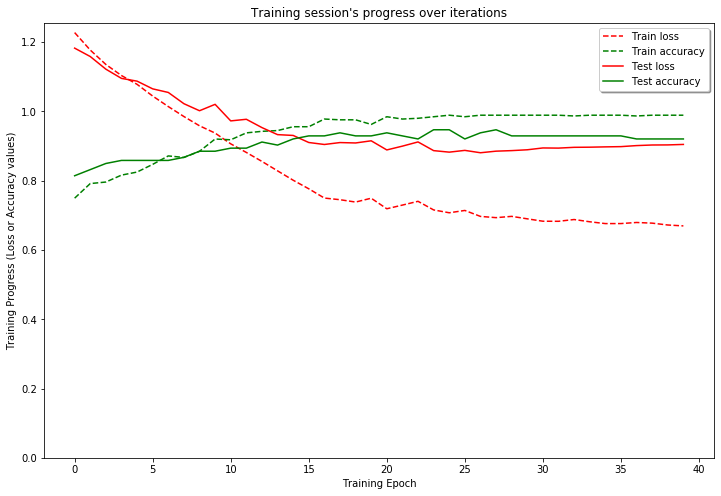

In [24]:
plt.figure(figsize=(12, 8))

plt.plot(np.array(history['train_loss']), "r--", label="Train loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")

plt.plot(np.array(history['test_loss']), "r-", label="Test loss")
plt.plot(np.array(history['test_acc']), "g-", label="Test accuracy")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()

In [25]:
#activity
LABELS = [1,2]

In [26]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

In [27]:
#max_test = np.argmax(y_test, axis=1)
#ls = list(max_test)
#ls


In [28]:
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)

max_test1 = max_test.tolist()
print (max_test1)
print (len(max_test1))
max_predictions1 = max_predictions.tolist()
print(max_predictions1)
print(len(max_predictions1))

confusion_matrix(max_test1, max_predictions1)


[1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
113
[0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
113


array([[86,  4],
       [ 5, 18]])

In [29]:
def data_reshaping(df):
    #df['activity'].value_counts().plot(kind='bar', title='Testing examples by activity type');
    N_TIME_STEPS = 500
    N_FEATURES = 6
    step = 100
    segments = []
    test_labels = []
    for i in range(0, len(df) - N_TIME_STEPS, step):
        xs = df['x-axis'].values[i: i + N_TIME_STEPS]
        ys = df['y-axis'].values[i: i + N_TIME_STEPS]
        zs = df['z-axis'].values[i: i + N_TIME_STEPS]
        xsg = df['xg-axis'].values[i: i + N_TIME_STEPS]
        ysg = df['yg-axis'].values[i: i + N_TIME_STEPS]
        zsg = df['zg-axis'].values[i: i + N_TIME_STEPS]
        
        label = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
        segments.append([xs, ys, zs, xsg, ysg,zsg])
        test_labels.append(label)
    #print test_labels
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
    #test_labels = np.asarray(pd.get_dummies(test_labels), dtype = np.float32)
    #X_train, X_test, y_train, y_test = train_test_split(
        #reshaped_segments, test_labels, test_size=0.99, random_state=RANDOM_SEED)
    X_test = reshaped_segments
    y_test = test_labels
    
    #print test_labels
    return X_test, y_test
    

In [47]:
columns1=['ep','x-axis', 'y-axis' ,'z-axis' ,'xg-axis' ,'yg-axis' ,'zg-axis']
test = pd.read_csv('Act1.csv', header = None, names = columns1)
test

,ep,x-axis,y-axis,z-axis,xg-axis,yg-axis,zg-axis
0,0.000000e+00,1.0000,2.0000,3.0000,4.0000,5.0000,6.0000
1,1.574685e+12,0.0934,-0.1225,0.7399,37.8049,-152.7439,-26.8902
2,1.574685e+12,0.1689,-0.0379,0.9245,45.0610,-147.9878,-25.7317
3,1.574685e+12,0.2049,0.0226,1.0523,53.5366,-134.3902,-27.1341
4,1.574685e+12,0.2417,0.0170,1.1290,53.2317,-117.6829,-25.9146
...,...,...,...,...,...,...,...
41939,1.574686e+12,0.2233,0.2618,0.9177,-11.9512,-52.8659,12.9878
41940,1.574686e+12,0.5472,0.1774,0.9739,-8.2927,-43.6585,-5.8537
41941,1.574686e+12,0.7087,0.1389,1.0635,-16.8902,-36.5244,-9.0244
41942,1.574686e+12,0.3517,0.1758,1.0333,-19.1463,-5.5488,-16.7683


In [48]:
test['activity']=1

In [49]:
test

,ep,x-axis,y-axis,z-axis,xg-axis,yg-axis,zg-axis,activity
0,0.000000e+00,1.0000,2.0000,3.0000,4.0000,5.0000,6.0000,1
1,1.574685e+12,0.0934,-0.1225,0.7399,37.8049,-152.7439,-26.8902,1
2,1.574685e+12,0.1689,-0.0379,0.9245,45.0610,-147.9878,-25.7317,1
3,1.574685e+12,0.2049,0.0226,1.0523,53.5366,-134.3902,-27.1341,1
4,1.574685e+12,0.2417,0.0170,1.1290,53.2317,-117.6829,-25.9146,1
...,...,...,...,...,...,...,...,...
41939,1.574686e+12,0.2233,0.2618,0.9177,-11.9512,-52.8659,12.9878,1
41940,1.574686e+12,0.5472,0.1774,0.9739,-8.2927,-43.6585,-5.8537,1
41941,1.574686e+12,0.7087,0.1389,1.0635,-16.8902,-36.5244,-9.0244,1
41942,1.574686e+12,0.3517,0.1758,1.0333,-19.1463,-5.5488,-16.7683,1


In [50]:
x_test1, y_test1 = data_reshaping(test)

In [51]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver = tf.train.import_meta_graph("./checkpoint/activity_3.ckpt.meta")
    saver.restore(sess,tf.train.latest_checkpoint("./checkpoint"))
    predictions1= sess.run(pred_softmax, feed_dict={X: x_test1})
    #predictions, acc_final, loss_final = sess.run([pred_softmax, a, feed_dict={X: X_test1, Y: y_test1})
    sess.close()

INFO:tensorflow:Restoring parameters from ./checkpoint/activity_3.ckpt


In [52]:
y_ls = list(y_test1)
print(y_ls)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [53]:
max_predictions1 = np.argmax(predictions1, axis=1) + 1
print(len(list(max_predictions1)))
print((max_predictions1))

415
[1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 1 2 1 1 1 1 2 2 2 2 2 1 1 2 2 2
 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 2 1 1 1 2 1 2 2 1 1 1 1 2 2 2 2 2 2 2 1
 1 1 1 1 2 2 2 2 1 2 2 2 1 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 1 1 2
 2 1 2 2 1 1 1 1 1 1 2 1 1 1 1 1 2 2 2 2 1 1 2 1 1 1 1 1 1 1 1 1 2 2 2 2 2
 2 1 1 1 2 2 1 1 1 1 1 1 1 1 1 2 2 1 2 2 2 2 1 1 1 1 2 2 2 2 2 2 1 1 2 1 1
 1 1 1 1 1 1 1 1 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 2 1 1 2 1 2
 2 2 2 2 2 2 2 1 1 2 1 1 2 1 2 1 2 1 1 2 1 1 2 1 1 2 1 1 2 1 2 1 1 1 2 2 2
 2 2 2 2 2 1 2 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 2 2 2 2 1 1 1 1 1 2
 2 2 1 2 1 1 1 1 1 2 1 2 1 1 1 1 1 2 2 2 1 1 1 1 2 1 1 2 1 2 1 2 1 1 2 1 2
 2 2 1 2 1 1 2 2 1 2 2 2 1 1 1 1 1 1 2 2 2 1 1 2 2 2 1 1 2 2 1 2 2 2 1 1 1
 1 2 1 2 2 1 1 1 1 1 1 2 2 2 1 2 2 2 1 1 2 2 2 2 1 1 1 1 1 2 2 2 1 1 1 1 1
 2 1 1 1 1 1 1 2]


In [54]:
a=confusion_matrix(y_ls, max_predictions1)
print(a)
accuracy = ((a[0][1])*100)/(len(max_predictions1))
print(accuracy)

[[237 178]
 [  0   0]]
42.89156626506024
